Работу выполнила:Масаева Ольга
Источник данных: https://www.kaggle.com/competitions/santander-customer-transaction-prediction 

* шаг 1 - импорт библиотек

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import scipy
import pca
import os
import logging
import datetime
from scipy import stats
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import lightgbm as lgb
from lightgbm import plot_importance
import xgboost as xgb
import em
import sklearn
import warnings
warnings.filterwarnings('ignore')

* шаг 2 - импорт данных 

In [2]:
# чтение обучающих данных
train_data = pd.read_csv("/santander-customer-transaction-prediction/train.csv")

In [3]:
# чтение тестовых данных
test_data = pd.read_csv("/santander-customer-transaction-prediction/test.csv")

* шаг 3 - взгляд на данные

В обучающей выборке 200 вещественных признаков(var_0-199) и один целевой бинарный признак(target) - имеется задача бинарной классификации. Всего в выборке 200000 записей.

In [4]:
print(train_data.head())

   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0

In [5]:
train_data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


В тестирующей выборке то же число признаков  и также 200000 записей для выполнения прогноза( используется для посылки в kaggle)

In [6]:
test_data.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [7]:
test_data.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Видно , что выборка несбалансированная: количество записей со значением 0 примерно в 9 раз больше чем со значением 1.

<AxesSubplot:xlabel='target', ylabel='count'>

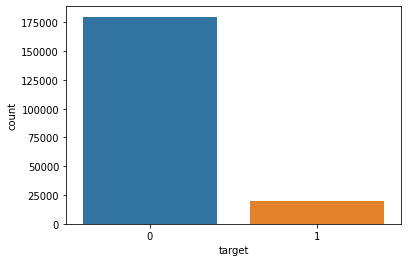

In [8]:
# Подсчет 0 и 1
sns.countplot(train_data['target'])

In [9]:
# доля записей с target = 1 и target = 0
print(train_data["target"].value_counts()[1]/train_data.shape[0],train_data["target"].value_counts()[0]/train_data.shape[0])

0.10049 0.89951


In [10]:
from scipy import stats
rng = np.random.default_rng()
x = stats.norm.rvs(loc=5, scale=3, size=100, random_state=rng)
shapiro_test = stats.shapiro(x)
shapiro_test

ShapiroResult(statistic=0.9862578511238098, pvalue=0.3896794021129608)

In [11]:
features = train_data.columns.values[2:202]
q = train_data[features].mean(axis=1)
scipy.stats.shapiro((q - q.mean())/q.std())

ShapiroResult(statistic=1.0000227689743042, pvalue=1.0)

In [12]:
for i in range(0,200):
    n = "var_" + str(i)
    print(scipy.stats.shapiro((train_data[n] - train_data[n].mean())/ (train_data[n].std())))

ShapiroResult(statistic=0.9938966035842896, pvalue=0.0)
ShapiroResult(statistic=0.992820143699646, pvalue=0.0)
ShapiroResult(statistic=0.9917315244674683, pvalue=0.0)
ShapiroResult(statistic=0.9937424659729004, pvalue=0.0)
ShapiroResult(statistic=0.9948575496673584, pvalue=0.0)
ShapiroResult(statistic=0.9907069206237793, pvalue=0.0)
ShapiroResult(statistic=0.9956332445144653, pvalue=0.0)
ShapiroResult(statistic=0.991101861000061, pvalue=0.0)
ShapiroResult(statistic=0.9859070777893066, pvalue=0.0)
ShapiroResult(statistic=0.9844582676887512, pvalue=0.0)
ShapiroResult(statistic=0.9959120750427246, pvalue=0.0)
ShapiroResult(statistic=0.9982025623321533, pvalue=1.1724418070891532e-36)
ShapiroResult(statistic=0.9948095083236694, pvalue=0.0)
ShapiroResult(statistic=0.9878911972045898, pvalue=0.0)
ShapiroResult(statistic=0.9888185262680054, pvalue=0.0)
ShapiroResult(statistic=0.994330108165741, pvalue=0.0)
ShapiroResult(statistic=0.9946680068969727, pvalue=0.0)
ShapiroResult(statistic=0.996791

ShapiroResult(statistic=0.9967253804206848, pvalue=0.0)
ShapiroResult(statistic=0.9939494729042053, pvalue=0.0)
ShapiroResult(statistic=0.9901758432388306, pvalue=0.0)
ShapiroResult(statistic=0.9964722990989685, pvalue=0.0)
ShapiroResult(statistic=0.9967504143714905, pvalue=0.0)
ShapiroResult(statistic=0.995892345905304, pvalue=0.0)
ShapiroResult(statistic=0.9941177368164062, pvalue=0.0)
ShapiroResult(statistic=0.99855637550354, pvalue=2.465784173868018e-33)
ShapiroResult(statistic=0.9968816637992859, pvalue=1.401298464324817e-45)
ShapiroResult(statistic=0.9975300431251526, pvalue=9.060795870324267e-42)
ShapiroResult(statistic=0.9984147548675537, pvalue=9.86022798980226e-35)
ShapiroResult(statistic=0.9906948208808899, pvalue=0.0)
ShapiroResult(statistic=0.9925433397293091, pvalue=0.0)
ShapiroResult(statistic=0.9972280859947205, pvalue=1.0369608636003646e-43)
ShapiroResult(statistic=0.9917170405387878, pvalue=0.0)
ShapiroResult(statistic=0.993720293045044, pvalue=0.0)
ShapiroResult(stat

Гистограмма первого признака - визуально выглядит как смесь распределений

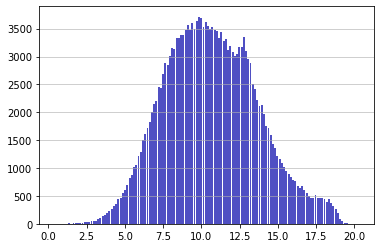

In [13]:

plt.hist(train_data["var_0"],bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

Гистограмма первого признака , разделенного по target - визуально похожи

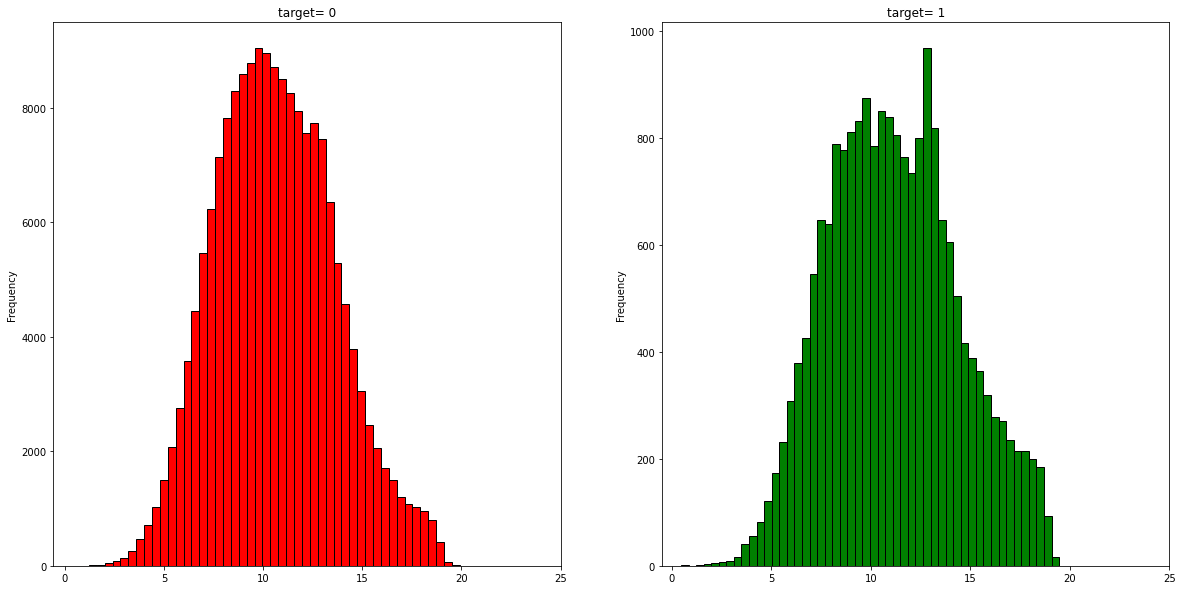

In [57]:
# Гистограммы var_0 разделенные по значению target
f,ax=plt.subplots(1,2,figsize=(20,10))
train_data[train_data['target']==0].var_0.plot.hist(ax=ax[0],bins=50,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,30,5))
ax[0].set_xticks(x1)
train_data[train_data['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=50,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,30,5))
ax[1].set_xticks(x2)
plt.show()

Несмотря на внешнюю схожесть распределений выше , тест на однородность Колмогорова -Смирнова они не прошли , так как значение pvalue ниже  1%

In [51]:
q = train_data[train_data['target']==0].var_0
p = train_data[train_data['target']==1].var_0
print(q.mean(),p.mean())
stats.ks_2samp((q - q.mean())/q.var(), (p  - p.mean())/p.var())

10.62668097464175 11.15641803662056


KstestResult(statistic=0.02393935688821569, pvalue=1.968599037249132e-09)

Гистограммы 21 и 101 признака.

<AxesSubplot:>

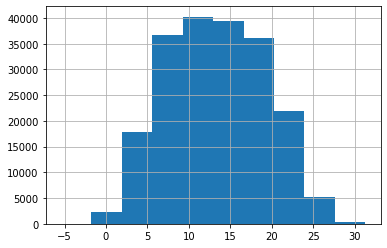

In [16]:
train_data["var_20"].hist()


<AxesSubplot:>

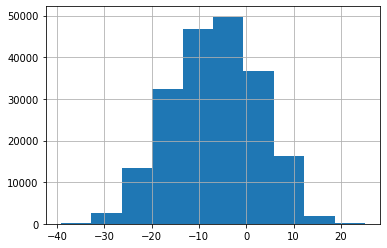

In [17]:
train_data["var_100"].hist()

<AxesSubplot:>

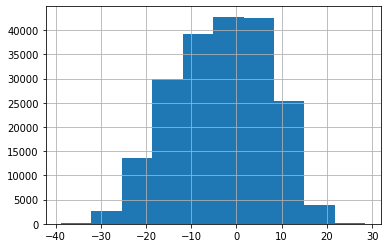

In [18]:
train_data["var_199"].hist()

Гистограмма средних значений признаков

<AxesSubplot:ylabel='Frequency'>

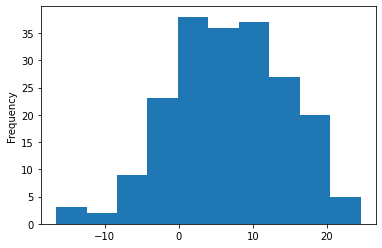

In [20]:

train_data[train_data.columns[2:]].mean().plot(kind='hist')

Гистограммы Распределения средних значений признаков по тестовой и обучающей выборке 

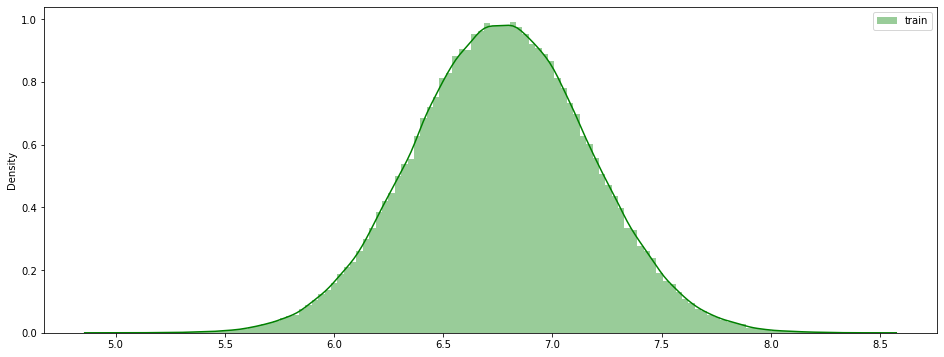

In [21]:
features = train_data.columns.values[2:202]
plt.figure(figsize=(16,6))
sns.distplot(train_data[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
#sns.distplot(test_data[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Гистограммы Распределения среднеквадртических отклоненй значений признаков по тестовой и обучающей выборке

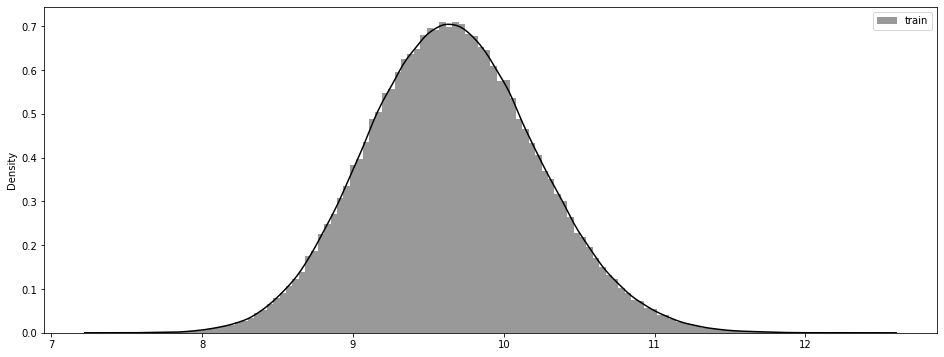

In [24]:

plt.figure(figsize=(16,6))
sns.distplot(train_data[features].std(axis=1),color="black", kde=True,bins=120, label='train')
#sns.distplot(test_data[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();
plt.show()

* шаг 4 - корреляционный анализ

Далее представлено начало и конец списка пар признаков (кроме идентичных пар) , отсортированных по значениям 
их модуля коэфицента корреляции пирсона. Наибольшее значение коэфицента корреляции - 0.009844, что говорит о
независимости признаков друг от друга

In [25]:
# Корреляция признаков
correlations = train_data[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


In [26]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


* шаг 5 - уменьшение размерности вектора признаков

Для уменьшения размерности вектора признаков можно применять метод главных компонент(PCA)

In [27]:
x = train_data[features]
y = train_data['target']

In [30]:
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)
x_scaler_df = pd.DataFrame(x_scaler, columns=x.columns)

pca = sklearn.decomposition.PCA(n_components=2)
x_scaler_pca = pca.fit_transform(x_scaler)
x_scaler_pca_df = pd.DataFrame(x_scaler_pca)

In [31]:
print("Results of variance in 2 columns used : {}".format(pca.explained_variance_ratio_))

Results of variance in 2 columns used : [0.0055908  0.00513175]


In [32]:
# Так как потеря данных незначительная - 0.01 , метод главных компонент имеет место быть

In [33]:
print("Results of variance : {}".format(sum(pca.explained_variance_ratio_)))

Results of variance : 0.010722553341733543


In [34]:
x_scaler_pca_df['target'] = y

In [35]:
print(x_scaler_pca_df)

               0         1  target
0      -0.849462 -0.736794       0
1       1.331346  0.881771       0
2       0.042545  0.222660       0
3       1.868598 -0.073267       0
4       1.091182 -0.169551       0
...          ...       ...     ...
199995 -0.363969  0.182249       0
199996 -0.769299 -0.103277       0
199997  1.334771 -0.887177       0
199998 -0.282675 -0.354580       0
199999 -0.817783  0.725829       0

[200000 rows x 3 columns]


Результат уменьшение размерности - Фиолетовые точки соответствуют точкам с target = 0, желтые c target = 1

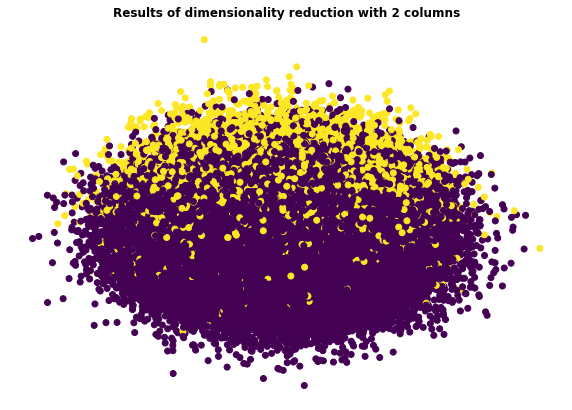

In [36]:
fig = plt.figure(figsize=(10,7))
plt.scatter(x_scaler_pca_df.loc[:, 1], x_scaler_pca_df.loc[:, 0], c=y)
plt.axis('off')
plt.title("Results of dimensionality reduction with 2 columns", fontweight="bold")
plt.show()

* шаг 6 использование моделей

В качестве моделей было взято 2 модели - логистическая регрессия и LGB. Обе модели показали неплохие результаты и работали достаточно быстро даже без сокращения размерности

In [37]:
# разделение выборок
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [38]:
#  Функция для подсчета метрик
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('Confusion_matrix:\n', confusion)
    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

Модель Логистической регрессии показала на валидационны данных данных хорошую точность.

In [39]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
pred = log_reg.predict(x_test)

In [41]:
get_clf_eval(y_test, pred)

Confusion_matrix:
 [[35547   417]
 [ 3058   978]]
Accuracy: 0.9131
Precision: 0.7011
Recall: 0.2423
F1: 0.3602
AUC: 0.6154


Логистическая регрессия при сокращенном числе признаков имеет меньшую точность чем оригинальная

In [58]:
xx  = x_scaler_pca_df[x_scaler_pca_df.columns.values[0:2]]
yy =  x_scaler_pca_df['target']
xx_train, xx_test, yy_train, yy_test = train_test_split(xx, yy, test_size=0.2)
log_reg1 = LogisticRegression()
log_reg1.fit(xx_train,yy_train)
pred1 = log_reg1.predict(xx_test)
get_clf_eval(yy_test, pred1)

Confusion_matrix:
 [[35796   156]
 [ 3837   211]]
Accuracy: 0.9002
Precision: 0.5749
Recall: 0.0521
F1: 0.0956
AUC: 0.5239


In [ ]:
Результаты модели по точности на валидационной выборке тоже положительные

In [74]:
lgbm_x_test, lgbm_x_val, lgbm_y_test, lgbm_y_val = train_test_split(x_test, y_test, test_size=0.5)

In [75]:
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(lgbm_x_val, label=lgbm_y_val)
params = {
    'device' : 'cpu',
    'n_estimators': 7000,
    'num_leaves': 20,
    'max_depth': -1,
    'min_data_in_leaf': 80,
    'learning_rate': 0.008,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'n_jobs': -1
}

In [83]:
lgbm_model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=100)

[LightGBM] [Info] Number of positive: 15969, number of negative: 144031
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099806 -> initscore=-2.199379
[LightGBM] [Info] Start training from score -2.199379
[1]	train's auc: 0.647534
Training until validation scores don't improve for 100 rounds
[2]	train's auc: 0.658946
[3]	train's auc: 0.671199
[4]	train's auc: 0.669877
[5]	train's auc: 0.671101
[6]	train's auc: 0.671682
[7]	train's auc: 0.672926
[8]	train's auc: 0.674845
[9]	train's auc: 0.675419
[10]	train's auc: 0.677123
[11]	train's auc: 0.67858
[12]	train's auc: 0.679293
[13]	train's auc: 0.680049
[14]	train's auc: 0.682892
[15]	train's auc: 0.683746
[16]	train's auc: 0.684189
[17]	train's au

[279]	train's auc: 0.811434
[280]	train's auc: 0.81158
[281]	train's auc: 0.81175
[282]	train's auc: 0.811837
[283]	train's auc: 0.812029
[284]	train's auc: 0.812109
[285]	train's auc: 0.812408
[286]	train's auc: 0.812514
[287]	train's auc: 0.812578
[288]	train's auc: 0.812727
[289]	train's auc: 0.81288
[290]	train's auc: 0.813075
[291]	train's auc: 0.813303
[292]	train's auc: 0.813602
[293]	train's auc: 0.813858
[294]	train's auc: 0.814083
[295]	train's auc: 0.814331
[296]	train's auc: 0.814515
[297]	train's auc: 0.814726
[298]	train's auc: 0.814875
[299]	train's auc: 0.814978
[300]	train's auc: 0.815115
[301]	train's auc: 0.815178
[302]	train's auc: 0.815311
[303]	train's auc: 0.815543
[304]	train's auc: 0.815679
[305]	train's auc: 0.815746
[306]	train's auc: 0.815852
[307]	train's auc: 0.816025
[308]	train's auc: 0.816142
[309]	train's auc: 0.816331
[310]	train's auc: 0.816584
[311]	train's auc: 0.816723
[312]	train's auc: 0.816772
[313]	train's auc: 0.816923
[314]	train's auc: 0.81

[574]	train's auc: 0.8424
[575]	train's auc: 0.842446
[576]	train's auc: 0.842479
[577]	train's auc: 0.842578
[578]	train's auc: 0.842679
[579]	train's auc: 0.842799
[580]	train's auc: 0.842834
[581]	train's auc: 0.842878
[582]	train's auc: 0.842929
[583]	train's auc: 0.842984
[584]	train's auc: 0.843014
[585]	train's auc: 0.843082
[586]	train's auc: 0.843121
[587]	train's auc: 0.843147
[588]	train's auc: 0.843192
[589]	train's auc: 0.843316
[590]	train's auc: 0.843345
[591]	train's auc: 0.843394
[592]	train's auc: 0.843451
[593]	train's auc: 0.843559
[594]	train's auc: 0.843639
[595]	train's auc: 0.8437
[596]	train's auc: 0.843773
[597]	train's auc: 0.843832
[598]	train's auc: 0.843927
[599]	train's auc: 0.843981
[600]	train's auc: 0.844042
[601]	train's auc: 0.844085
[602]	train's auc: 0.84415
[603]	train's auc: 0.844207
[604]	train's auc: 0.844257
[605]	train's auc: 0.844286
[606]	train's auc: 0.844314
[607]	train's auc: 0.844415
[608]	train's auc: 0.844452
[609]	train's auc: 0.8445

[869]	train's auc: 0.856659
[870]	train's auc: 0.856695
[871]	train's auc: 0.856749
[872]	train's auc: 0.85679
[873]	train's auc: 0.856786
[874]	train's auc: 0.85687
[875]	train's auc: 0.856923
[876]	train's auc: 0.856945
[877]	train's auc: 0.856976
[878]	train's auc: 0.857
[879]	train's auc: 0.857045
[880]	train's auc: 0.857076
[881]	train's auc: 0.857115
[882]	train's auc: 0.85717
[883]	train's auc: 0.857209
[884]	train's auc: 0.857233
[885]	train's auc: 0.857253
[886]	train's auc: 0.857292
[887]	train's auc: 0.857336
[888]	train's auc: 0.857377
[889]	train's auc: 0.857369
[890]	train's auc: 0.857399
[891]	train's auc: 0.857438
[892]	train's auc: 0.857478
[893]	train's auc: 0.857519
[894]	train's auc: 0.857545
[895]	train's auc: 0.857582
[896]	train's auc: 0.857623
[897]	train's auc: 0.857669
[898]	train's auc: 0.857703
[899]	train's auc: 0.857716
[900]	train's auc: 0.85773
[901]	train's auc: 0.857772
[902]	train's auc: 0.857798
[903]	train's auc: 0.857842
[904]	train's auc: 0.857899

[1158]	train's auc: 0.866113
[1159]	train's auc: 0.866137
[1160]	train's auc: 0.866165
[1161]	train's auc: 0.8662
[1162]	train's auc: 0.866224
[1163]	train's auc: 0.866271
[1164]	train's auc: 0.866285
[1165]	train's auc: 0.866304
[1166]	train's auc: 0.866314
[1167]	train's auc: 0.866318
[1168]	train's auc: 0.866346
[1169]	train's auc: 0.866367
[1170]	train's auc: 0.866415
[1171]	train's auc: 0.866466
[1172]	train's auc: 0.866492
[1173]	train's auc: 0.866509
[1174]	train's auc: 0.866516
[1175]	train's auc: 0.866517
[1176]	train's auc: 0.866549
[1177]	train's auc: 0.866582
[1178]	train's auc: 0.866601
[1179]	train's auc: 0.866642
[1180]	train's auc: 0.866694
[1181]	train's auc: 0.866708
[1182]	train's auc: 0.866726
[1183]	train's auc: 0.866754
[1184]	train's auc: 0.866798
[1185]	train's auc: 0.86681
[1186]	train's auc: 0.866822
[1187]	train's auc: 0.866845
[1188]	train's auc: 0.866893
[1189]	train's auc: 0.86694
[1190]	train's auc: 0.866964
[1191]	train's auc: 0.866981
[1192]	train's auc

[1443]	train's auc: 0.872341
[1444]	train's auc: 0.872357
[1445]	train's auc: 0.872373
[1446]	train's auc: 0.87237
[1447]	train's auc: 0.872412
[1448]	train's auc: 0.872426
[1449]	train's auc: 0.872449
[1450]	train's auc: 0.872476
[1451]	train's auc: 0.872495
[1452]	train's auc: 0.872496
[1453]	train's auc: 0.872512
[1454]	train's auc: 0.872529
[1455]	train's auc: 0.872542
[1456]	train's auc: 0.872553
[1457]	train's auc: 0.872583
[1458]	train's auc: 0.872599
[1459]	train's auc: 0.872614
[1460]	train's auc: 0.872622
[1461]	train's auc: 0.872645
[1462]	train's auc: 0.872677
[1463]	train's auc: 0.872717
[1464]	train's auc: 0.872726
[1465]	train's auc: 0.872747
[1466]	train's auc: 0.872771
[1467]	train's auc: 0.872788
[1468]	train's auc: 0.872819
[1469]	train's auc: 0.872829
[1470]	train's auc: 0.872855
[1471]	train's auc: 0.872877
[1472]	train's auc: 0.872911
[1473]	train's auc: 0.872936
[1474]	train's auc: 0.872948
[1475]	train's auc: 0.872965
[1476]	train's auc: 0.872987
[1477]	train's 

[1727]	train's auc: 0.877066
[1728]	train's auc: 0.877087
[1729]	train's auc: 0.877104
[1730]	train's auc: 0.877114
[1731]	train's auc: 0.877138
[1732]	train's auc: 0.877149
[1733]	train's auc: 0.877175
[1734]	train's auc: 0.877176
[1735]	train's auc: 0.877182
[1736]	train's auc: 0.87719
[1737]	train's auc: 0.87719
[1738]	train's auc: 0.877206
[1739]	train's auc: 0.877218
[1740]	train's auc: 0.877233
[1741]	train's auc: 0.877252
[1742]	train's auc: 0.877266
[1743]	train's auc: 0.877286
[1744]	train's auc: 0.877297
[1745]	train's auc: 0.877327
[1746]	train's auc: 0.877347
[1747]	train's auc: 0.877358
[1748]	train's auc: 0.877367
[1749]	train's auc: 0.877381
[1750]	train's auc: 0.877413
[1751]	train's auc: 0.877429
[1752]	train's auc: 0.877439
[1753]	train's auc: 0.877444
[1754]	train's auc: 0.877451
[1755]	train's auc: 0.877471
[1756]	train's auc: 0.877484
[1757]	train's auc: 0.877508
[1758]	train's auc: 0.877508
[1759]	train's auc: 0.877539
[1760]	train's auc: 0.877562
[1761]	train's a

[2011]	train's auc: 0.880557
[2012]	train's auc: 0.880581
[2013]	train's auc: 0.880591
[2014]	train's auc: 0.880621
[2015]	train's auc: 0.880632
[2016]	train's auc: 0.880641
[2017]	train's auc: 0.880663
[2018]	train's auc: 0.88067
[2019]	train's auc: 0.880668
[2020]	train's auc: 0.880671
[2021]	train's auc: 0.880679
[2022]	train's auc: 0.880671
[2023]	train's auc: 0.880683
[2024]	train's auc: 0.880691
[2025]	train's auc: 0.880705
[2026]	train's auc: 0.880704
[2027]	train's auc: 0.880724
[2028]	train's auc: 0.88073
[2029]	train's auc: 0.880737
[2030]	train's auc: 0.880755
[2031]	train's auc: 0.880769
[2032]	train's auc: 0.880795
[2033]	train's auc: 0.880804
[2034]	train's auc: 0.880814
[2035]	train's auc: 0.880821
[2036]	train's auc: 0.880827
[2037]	train's auc: 0.880844
[2038]	train's auc: 0.880841
[2039]	train's auc: 0.880851
[2040]	train's auc: 0.880856
[2041]	train's auc: 0.880871
[2042]	train's auc: 0.880869
[2043]	train's auc: 0.880887
[2044]	train's auc: 0.880889
[2045]	train's a

[2296]	train's auc: 0.88336
[2297]	train's auc: 0.883367
[2298]	train's auc: 0.883378
[2299]	train's auc: 0.883372
[2300]	train's auc: 0.883386
[2301]	train's auc: 0.883381
[2302]	train's auc: 0.883388
[2303]	train's auc: 0.8834
[2304]	train's auc: 0.883415
[2305]	train's auc: 0.883433
[2306]	train's auc: 0.883442
[2307]	train's auc: 0.88345
[2308]	train's auc: 0.883473
[2309]	train's auc: 0.883486
[2310]	train's auc: 0.883491
[2311]	train's auc: 0.883499
[2312]	train's auc: 0.88351
[2313]	train's auc: 0.883508
[2314]	train's auc: 0.883514
[2315]	train's auc: 0.883528
[2316]	train's auc: 0.883529
[2317]	train's auc: 0.883524
[2318]	train's auc: 0.88354
[2319]	train's auc: 0.883541
[2320]	train's auc: 0.883545
[2321]	train's auc: 0.883556
[2322]	train's auc: 0.883571
[2323]	train's auc: 0.883596
[2324]	train's auc: 0.883603
[2325]	train's auc: 0.883608
[2326]	train's auc: 0.88362
[2327]	train's auc: 0.883637
[2328]	train's auc: 0.883647
[2329]	train's auc: 0.883654
[2330]	train's auc: 0

[2581]	train's auc: 0.885493
[2582]	train's auc: 0.885507
[2583]	train's auc: 0.885516
[2584]	train's auc: 0.885515
[2585]	train's auc: 0.885513
[2586]	train's auc: 0.885523
[2587]	train's auc: 0.885535
[2588]	train's auc: 0.885534
[2589]	train's auc: 0.885539
[2590]	train's auc: 0.885544
[2591]	train's auc: 0.885543
[2592]	train's auc: 0.885552
[2593]	train's auc: 0.885556
[2594]	train's auc: 0.885558
[2595]	train's auc: 0.885564
[2596]	train's auc: 0.885568
[2597]	train's auc: 0.885589
[2598]	train's auc: 0.885595
[2599]	train's auc: 0.885603
[2600]	train's auc: 0.885611
[2601]	train's auc: 0.885627
[2602]	train's auc: 0.885638
[2603]	train's auc: 0.885645
[2604]	train's auc: 0.885667
[2605]	train's auc: 0.885667
[2606]	train's auc: 0.885677
[2607]	train's auc: 0.885687
[2608]	train's auc: 0.88569
[2609]	train's auc: 0.885697
[2610]	train's auc: 0.885703
[2611]	train's auc: 0.88572
[2612]	train's auc: 0.885729
[2613]	train's auc: 0.885753
[2614]	train's auc: 0.885764
[2615]	train's a

[2866]	train's auc: 0.887213
[2867]	train's auc: 0.88722
[2868]	train's auc: 0.887236
[2869]	train's auc: 0.887228
[2870]	train's auc: 0.887232
[2871]	train's auc: 0.887232
[2872]	train's auc: 0.887232
[2873]	train's auc: 0.887238
[2874]	train's auc: 0.887251
[2875]	train's auc: 0.887253
[2876]	train's auc: 0.887253
[2877]	train's auc: 0.887257
[2878]	train's auc: 0.887269
[2879]	train's auc: 0.887267
[2880]	train's auc: 0.887279
[2881]	train's auc: 0.887283
[2882]	train's auc: 0.887284
[2883]	train's auc: 0.887298
[2884]	train's auc: 0.887306
[2885]	train's auc: 0.887308
[2886]	train's auc: 0.887309
[2887]	train's auc: 0.887323
[2888]	train's auc: 0.887321
[2889]	train's auc: 0.887324
[2890]	train's auc: 0.887327
[2891]	train's auc: 0.88733
[2892]	train's auc: 0.887321
[2893]	train's auc: 0.887334
[2894]	train's auc: 0.887345
[2895]	train's auc: 0.887348
[2896]	train's auc: 0.887364
[2897]	train's auc: 0.887361
[2898]	train's auc: 0.887365
[2899]	train's auc: 0.887364
[2900]	train's a

[3151]	train's auc: 0.888663
[3152]	train's auc: 0.888668
[3153]	train's auc: 0.888677
[3154]	train's auc: 0.88868
[3155]	train's auc: 0.888681
[3156]	train's auc: 0.888682
[3157]	train's auc: 0.888675
[3158]	train's auc: 0.888686
[3159]	train's auc: 0.888696
[3160]	train's auc: 0.8887
[3161]	train's auc: 0.888707
[3162]	train's auc: 0.888704
[3163]	train's auc: 0.888718
[3164]	train's auc: 0.888731
[3165]	train's auc: 0.888746
[3166]	train's auc: 0.88874
[3167]	train's auc: 0.888754
[3168]	train's auc: 0.888747
[3169]	train's auc: 0.888753
[3170]	train's auc: 0.888751
[3171]	train's auc: 0.888748
[3172]	train's auc: 0.888753
[3173]	train's auc: 0.88876
[3174]	train's auc: 0.888763
[3175]	train's auc: 0.888769
[3176]	train's auc: 0.888784
[3177]	train's auc: 0.888788
[3178]	train's auc: 0.888793
[3179]	train's auc: 0.88879
[3180]	train's auc: 0.888797
[3181]	train's auc: 0.888806
[3182]	train's auc: 0.888813
[3183]	train's auc: 0.888808
[3184]	train's auc: 0.888814
[3185]	train's auc: 

[3436]	train's auc: 0.889814
[3437]	train's auc: 0.889821
[3438]	train's auc: 0.889823
[3439]	train's auc: 0.889819
[3440]	train's auc: 0.889822
[3441]	train's auc: 0.889819
[3442]	train's auc: 0.88983
[3443]	train's auc: 0.889833
[3444]	train's auc: 0.889833
[3445]	train's auc: 0.889836
[3446]	train's auc: 0.889837
[3447]	train's auc: 0.889843
[3448]	train's auc: 0.889851
[3449]	train's auc: 0.889857
[3450]	train's auc: 0.889857
[3451]	train's auc: 0.88987
[3452]	train's auc: 0.889871
[3453]	train's auc: 0.889881
[3454]	train's auc: 0.889888
[3455]	train's auc: 0.889893
[3456]	train's auc: 0.889895
[3457]	train's auc: 0.889893
[3458]	train's auc: 0.889887
[3459]	train's auc: 0.889904
[3460]	train's auc: 0.889899
[3461]	train's auc: 0.889898
[3462]	train's auc: 0.889903
[3463]	train's auc: 0.889907
[3464]	train's auc: 0.889911
[3465]	train's auc: 0.889922
[3466]	train's auc: 0.889918
[3467]	train's auc: 0.889926
[3468]	train's auc: 0.88993
[3469]	train's auc: 0.889928
[3470]	train's au

[3720]	train's auc: 0.890712
[3721]	train's auc: 0.890711
[3722]	train's auc: 0.890709
[3723]	train's auc: 0.890706
[3724]	train's auc: 0.890713
[3725]	train's auc: 0.890714
[3726]	train's auc: 0.890715
[3727]	train's auc: 0.89071
[3728]	train's auc: 0.890714
[3729]	train's auc: 0.89072
[3730]	train's auc: 0.890724
[3731]	train's auc: 0.890724
[3732]	train's auc: 0.890719
[3733]	train's auc: 0.890715
[3734]	train's auc: 0.890716
[3735]	train's auc: 0.890715
[3736]	train's auc: 0.89072
[3737]	train's auc: 0.890724
[3738]	train's auc: 0.890725
[3739]	train's auc: 0.890736
[3740]	train's auc: 0.890739
[3741]	train's auc: 0.890737
[3742]	train's auc: 0.890741
[3743]	train's auc: 0.890738
[3744]	train's auc: 0.890746
[3745]	train's auc: 0.890753
[3746]	train's auc: 0.890763
[3747]	train's auc: 0.890771
[3748]	train's auc: 0.890773
[3749]	train's auc: 0.890777
[3750]	train's auc: 0.890775
[3751]	train's auc: 0.890779
[3752]	train's auc: 0.890773
[3753]	train's auc: 0.890771
[3754]	train's au

[4005]	train's auc: 0.891455
[4006]	train's auc: 0.891459
[4007]	train's auc: 0.891469
[4008]	train's auc: 0.891476
[4009]	train's auc: 0.891474
[4010]	train's auc: 0.891482
[4011]	train's auc: 0.891488
[4012]	train's auc: 0.891484
[4013]	train's auc: 0.891488
[4014]	train's auc: 0.891485
[4015]	train's auc: 0.891485
[4016]	train's auc: 0.891485
[4017]	train's auc: 0.891484
[4018]	train's auc: 0.891487
[4019]	train's auc: 0.89149
[4020]	train's auc: 0.89149
[4021]	train's auc: 0.891491
[4022]	train's auc: 0.891492
[4023]	train's auc: 0.891501
[4024]	train's auc: 0.891507
[4025]	train's auc: 0.891503
[4026]	train's auc: 0.891507
[4027]	train's auc: 0.891508
[4028]	train's auc: 0.891511
[4029]	train's auc: 0.891512
[4030]	train's auc: 0.891522
[4031]	train's auc: 0.891532
[4032]	train's auc: 0.891534
[4033]	train's auc: 0.891536
[4034]	train's auc: 0.891536
[4035]	train's auc: 0.891534
[4036]	train's auc: 0.891532
[4037]	train's auc: 0.89153
[4038]	train's auc: 0.891529
[4039]	train's au

[4289]	train's auc: 0.892012
[4290]	train's auc: 0.892009
[4291]	train's auc: 0.892007
[4292]	train's auc: 0.892011
[4293]	train's auc: 0.892013
[4294]	train's auc: 0.892023
[4295]	train's auc: 0.892021
[4296]	train's auc: 0.892018
[4297]	train's auc: 0.892022
[4298]	train's auc: 0.892024
[4299]	train's auc: 0.892026
[4300]	train's auc: 0.892027
[4301]	train's auc: 0.892029
[4302]	train's auc: 0.892024
[4303]	train's auc: 0.892032
[4304]	train's auc: 0.892036
[4305]	train's auc: 0.892041
[4306]	train's auc: 0.892037
[4307]	train's auc: 0.892044
[4308]	train's auc: 0.892044
[4309]	train's auc: 0.892052
[4310]	train's auc: 0.892048
[4311]	train's auc: 0.892049
[4312]	train's auc: 0.892042
[4313]	train's auc: 0.892041
[4314]	train's auc: 0.89204
[4315]	train's auc: 0.892045
[4316]	train's auc: 0.892042
[4317]	train's auc: 0.89204
[4318]	train's auc: 0.892047
[4319]	train's auc: 0.892054
[4320]	train's auc: 0.892053
[4321]	train's auc: 0.892058
[4322]	train's auc: 0.892053
[4323]	train's a

[4575]	train's auc: 0.892541
[4576]	train's auc: 0.892546
[4577]	train's auc: 0.892549
[4578]	train's auc: 0.892552
[4579]	train's auc: 0.892551
[4580]	train's auc: 0.892554
[4581]	train's auc: 0.892559
[4582]	train's auc: 0.892556
[4583]	train's auc: 0.892562
[4584]	train's auc: 0.892561
[4585]	train's auc: 0.892563
[4586]	train's auc: 0.892569
[4587]	train's auc: 0.892571
[4588]	train's auc: 0.892581
[4589]	train's auc: 0.892581
[4590]	train's auc: 0.89259
[4591]	train's auc: 0.892591
[4592]	train's auc: 0.892594
[4593]	train's auc: 0.892599
[4594]	train's auc: 0.892596
[4595]	train's auc: 0.892596
[4596]	train's auc: 0.892595
[4597]	train's auc: 0.89259
[4598]	train's auc: 0.892589
[4599]	train's auc: 0.892592
[4600]	train's auc: 0.892592
[4601]	train's auc: 0.892595
[4602]	train's auc: 0.892599
[4603]	train's auc: 0.892597
[4604]	train's auc: 0.892598
[4605]	train's auc: 0.892596
[4606]	train's auc: 0.892595
[4607]	train's auc: 0.8926
[4608]	train's auc: 0.892601
[4609]	train's auc

[4860]	train's auc: 0.893013
[4861]	train's auc: 0.893012
[4862]	train's auc: 0.893004
[4863]	train's auc: 0.893006
[4864]	train's auc: 0.893012
[4865]	train's auc: 0.893013
[4866]	train's auc: 0.89301
[4867]	train's auc: 0.89301
[4868]	train's auc: 0.893013
[4869]	train's auc: 0.893017
[4870]	train's auc: 0.893023
[4871]	train's auc: 0.893019
[4872]	train's auc: 0.893029
[4873]	train's auc: 0.893028
[4874]	train's auc: 0.893025
[4875]	train's auc: 0.893024
[4876]	train's auc: 0.893021
[4877]	train's auc: 0.893024
[4878]	train's auc: 0.893021
[4879]	train's auc: 0.89302
[4880]	train's auc: 0.893024
[4881]	train's auc: 0.893025
[4882]	train's auc: 0.893026
[4883]	train's auc: 0.893024
[4884]	train's auc: 0.893024
[4885]	train's auc: 0.893021
[4886]	train's auc: 0.893031
[4887]	train's auc: 0.893032
[4888]	train's auc: 0.893031
[4889]	train's auc: 0.893039
[4890]	train's auc: 0.893046
[4891]	train's auc: 0.893047
[4892]	train's auc: 0.893047
[4893]	train's auc: 0.893051
[4894]	train's au

[5144]	train's auc: 0.893306
[5145]	train's auc: 0.893313
[5146]	train's auc: 0.893317
[5147]	train's auc: 0.893318
[5148]	train's auc: 0.893316
[5149]	train's auc: 0.893311
[5150]	train's auc: 0.893312
[5151]	train's auc: 0.893317
[5152]	train's auc: 0.893313
[5153]	train's auc: 0.893309
[5154]	train's auc: 0.893313
[5155]	train's auc: 0.89332
[5156]	train's auc: 0.893321
[5157]	train's auc: 0.89332
[5158]	train's auc: 0.893319
[5159]	train's auc: 0.893324
[5160]	train's auc: 0.893324
[5161]	train's auc: 0.893327
[5162]	train's auc: 0.893326
[5163]	train's auc: 0.893327
[5164]	train's auc: 0.893321
[5165]	train's auc: 0.893324
[5166]	train's auc: 0.893327
[5167]	train's auc: 0.893329
[5168]	train's auc: 0.893333
[5169]	train's auc: 0.893326
[5170]	train's auc: 0.893326
[5171]	train's auc: 0.893327
[5172]	train's auc: 0.893326
[5173]	train's auc: 0.893333
[5174]	train's auc: 0.893333
[5175]	train's auc: 0.893332
[5176]	train's auc: 0.893337
[5177]	train's auc: 0.893339
[5178]	train's a

[5429]	train's auc: 0.893453
[5430]	train's auc: 0.893452
[5431]	train's auc: 0.893453
[5432]	train's auc: 0.89345
[5433]	train's auc: 0.89345
[5434]	train's auc: 0.893451
[5435]	train's auc: 0.893449
[5436]	train's auc: 0.893448
[5437]	train's auc: 0.893451
[5438]	train's auc: 0.89345
[5439]	train's auc: 0.89345
[5440]	train's auc: 0.893457
[5441]	train's auc: 0.893456
[5442]	train's auc: 0.893457
[5443]	train's auc: 0.893463
[5444]	train's auc: 0.893461
[5445]	train's auc: 0.893463
[5446]	train's auc: 0.893466
[5447]	train's auc: 0.893466
[5448]	train's auc: 0.893467
[5449]	train's auc: 0.89347
[5450]	train's auc: 0.893467
[5451]	train's auc: 0.893467
[5452]	train's auc: 0.893469
[5453]	train's auc: 0.893474
[5454]	train's auc: 0.893472
[5455]	train's auc: 0.893473
[5456]	train's auc: 0.893477
[5457]	train's auc: 0.893474
[5458]	train's auc: 0.89348
[5459]	train's auc: 0.893487
[5460]	train's auc: 0.893486
[5461]	train's auc: 0.893495
[5462]	train's auc: 0.893495
[5463]	train's auc: 

[5713]	train's auc: 0.893625
[5714]	train's auc: 0.893624
[5715]	train's auc: 0.893628
[5716]	train's auc: 0.893628
[5717]	train's auc: 0.893626
[5718]	train's auc: 0.893628
[5719]	train's auc: 0.893627
[5720]	train's auc: 0.893628
[5721]	train's auc: 0.893629
[5722]	train's auc: 0.89363
[5723]	train's auc: 0.893631
[5724]	train's auc: 0.893629
[5725]	train's auc: 0.893626
[5726]	train's auc: 0.893625
[5727]	train's auc: 0.893628
[5728]	train's auc: 0.893631
[5729]	train's auc: 0.893629
[5730]	train's auc: 0.893633
[5731]	train's auc: 0.893636
[5732]	train's auc: 0.893639
[5733]	train's auc: 0.893644
[5734]	train's auc: 0.893641
[5735]	train's auc: 0.893638
[5736]	train's auc: 0.893631
[5737]	train's auc: 0.893626
[5738]	train's auc: 0.893629
[5739]	train's auc: 0.893629
[5740]	train's auc: 0.893631
[5741]	train's auc: 0.89363
[5742]	train's auc: 0.893638
[5743]	train's auc: 0.893636
[5744]	train's auc: 0.893629
[5745]	train's auc: 0.893623
[5746]	train's auc: 0.893622
[5747]	train's a

[5997]	train's auc: 0.893697
[5998]	train's auc: 0.893699
[5999]	train's auc: 0.893702
[6000]	train's auc: 0.893703
[6001]	train's auc: 0.893704
[6002]	train's auc: 0.893711
[6003]	train's auc: 0.893708
[6004]	train's auc: 0.893714
[6005]	train's auc: 0.893717
[6006]	train's auc: 0.893715
[6007]	train's auc: 0.893719
[6008]	train's auc: 0.893725
[6009]	train's auc: 0.893724
[6010]	train's auc: 0.893725
[6011]	train's auc: 0.893718
[6012]	train's auc: 0.893719
[6013]	train's auc: 0.893717
[6014]	train's auc: 0.893719
[6015]	train's auc: 0.893721
[6016]	train's auc: 0.893722
[6017]	train's auc: 0.893723
[6018]	train's auc: 0.893727
[6019]	train's auc: 0.893721
[6020]	train's auc: 0.893726
[6021]	train's auc: 0.893732
[6022]	train's auc: 0.893729
[6023]	train's auc: 0.893731
[6024]	train's auc: 0.893733
[6025]	train's auc: 0.893732
[6026]	train's auc: 0.893733
[6027]	train's auc: 0.893736
[6028]	train's auc: 0.893734
[6029]	train's auc: 0.893732
[6030]	train's auc: 0.89373
[6031]	train's 

[6284]	train's auc: 0.893868
[6285]	train's auc: 0.893868
[6286]	train's auc: 0.893869
[6287]	train's auc: 0.893867
[6288]	train's auc: 0.893869
[6289]	train's auc: 0.89387
[6290]	train's auc: 0.89387
[6291]	train's auc: 0.893876
[6292]	train's auc: 0.893874
[6293]	train's auc: 0.893872
[6294]	train's auc: 0.893872
[6295]	train's auc: 0.893867
[6296]	train's auc: 0.893867
[6297]	train's auc: 0.89387
[6298]	train's auc: 0.893869
[6299]	train's auc: 0.893865
[6300]	train's auc: 0.893866
[6301]	train's auc: 0.893865
[6302]	train's auc: 0.893872
[6303]	train's auc: 0.89387
[6304]	train's auc: 0.893868
[6305]	train's auc: 0.893869
[6306]	train's auc: 0.89387
[6307]	train's auc: 0.893871
[6308]	train's auc: 0.893874
[6309]	train's auc: 0.893871
[6310]	train's auc: 0.893873
[6311]	train's auc: 0.893874
[6312]	train's auc: 0.893878
[6313]	train's auc: 0.893878
[6314]	train's auc: 0.893879
[6315]	train's auc: 0.893883
[6316]	train's auc: 0.893886
[6317]	train's auc: 0.893885
[6318]	train's auc:

[6570]	train's auc: 0.893956
[6571]	train's auc: 0.893961
[6572]	train's auc: 0.893962
[6573]	train's auc: 0.893962
[6574]	train's auc: 0.893967
[6575]	train's auc: 0.893957
[6576]	train's auc: 0.893962
[6577]	train's auc: 0.89396
[6578]	train's auc: 0.89396
[6579]	train's auc: 0.893962
[6580]	train's auc: 0.893958
[6581]	train's auc: 0.893959
[6582]	train's auc: 0.893963
[6583]	train's auc: 0.893967
[6584]	train's auc: 0.893969
[6585]	train's auc: 0.893967
[6586]	train's auc: 0.893968
[6587]	train's auc: 0.893967
[6588]	train's auc: 0.893972
[6589]	train's auc: 0.893965
[6590]	train's auc: 0.893969
[6591]	train's auc: 0.893967
[6592]	train's auc: 0.89397
[6593]	train's auc: 0.893967
[6594]	train's auc: 0.893968
[6595]	train's auc: 0.893974
[6596]	train's auc: 0.89397
[6597]	train's auc: 0.893967
[6598]	train's auc: 0.893974
[6599]	train's auc: 0.893977
[6600]	train's auc: 0.893974
[6601]	train's auc: 0.893976
[6602]	train's auc: 0.893974
[6603]	train's auc: 0.893975
[6604]	train's auc

[6854]	train's auc: 0.894089
[6855]	train's auc: 0.894093
[6856]	train's auc: 0.894095
[6857]	train's auc: 0.894096
[6858]	train's auc: 0.894099
[6859]	train's auc: 0.894097
[6860]	train's auc: 0.894098
[6861]	train's auc: 0.8941
[6862]	train's auc: 0.894099
[6863]	train's auc: 0.894099
[6864]	train's auc: 0.894099
[6865]	train's auc: 0.894105
[6866]	train's auc: 0.894101
[6867]	train's auc: 0.894101
[6868]	train's auc: 0.894105
[6869]	train's auc: 0.894108
[6870]	train's auc: 0.894112
[6871]	train's auc: 0.894111
[6872]	train's auc: 0.894114
[6873]	train's auc: 0.894115
[6874]	train's auc: 0.894115
[6875]	train's auc: 0.894115
[6876]	train's auc: 0.894119
[6877]	train's auc: 0.894114
[6878]	train's auc: 0.894114
[6879]	train's auc: 0.894113
[6880]	train's auc: 0.89411
[6881]	train's auc: 0.894107
[6882]	train's auc: 0.894105
[6883]	train's auc: 0.89411
[6884]	train's auc: 0.894102
[6885]	train's auc: 0.8941
[6886]	train's auc: 0.894099
[6887]	train's auc: 0.894095
[6888]	train's auc: 

In [84]:
pred = lgbm_model.predict(lgbm_x_test)
pred = (pred >= 0.5).astype(int)

In [85]:
get_clf_eval(lgbm_y_test, pred)

Confusion_matrix:
 [[17779   133]
 [ 1463   625]]
Accuracy: 0.9202
Precision: 0.8245
Recall: 0.2993
F1: 0.4392
AUC: 0.6460


In [82]:
lgbm_xx_test, lgbm_xx_val, lgbm_yy_test, lgbm_yy_val = train_test_split(xx_test, yy_test, test_size=0.5)
train_data1 = lgb.Dataset(xx_train, label=yy_train)
val_data1 = lgb.Dataset(lgbm_xx_val, label=lgbm_yy_val)
params1 = {
    'device' : 'cpu',
    'n_estimators': 7000,
    'num_leaves': 60,
    'max_depth': -1,
    'min_data_in_leaf': 1,
    'learning_rate': 0.002,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'n_jobs': -1
}
lgbm_model1 = lgb.train(params1,
                  train_data1,
                  valid_sets=val_data1, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=100)
pred1 = lgbm_model1.predict(lgbm_xx_test)
pred1 = (pred1 >= 0.5).astype(int)
get_clf_eval(lgbm_yy_test, pred1)

[LightGBM] [Info] Number of positive: 16151, number of negative: 143849
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100944 -> initscore=-2.186782
[LightGBM] [Info] Start training from score -2.186782
[1]	train's auc: 0.715186
Training until validation scores don't improve for 100 rounds
[2]	train's auc: 0.715186
[3]	train's auc: 0.715186
[4]	train's auc: 0.715218
[5]	train's auc: 0.715393
[6]	train's auc: 0.715391
[7]	train's auc: 0.715538
[8]	train's auc: 0.715471
[9]	train's auc: 0.715614
[10]	train's auc: 0.715436
[11]	train's auc: 0.715343
[12]	train's auc: 0.715282
[13]	train's auc: 0.715154
[14]	train's auc: 0.71525
[15]	trai

In [79]:
print(xx_train)
print(yy_train)

               0         1
92758  -0.843875 -0.558882
120388  0.443045  0.264729
194084  0.043378 -0.013633
73015  -1.213296 -2.275215
134809  0.874047  0.787299
...          ...       ...
83786  -0.373674 -1.491603
56379  -1.838831  2.250157
186454 -0.955662 -0.016465
25129   0.523923  0.197759
2535   -0.193067  2.289664

[160000 rows x 2 columns]
92758     0
120388    0
194084    0
73015     0
134809    0
         ..
83786     1
56379     0
186454    1
25129     1
2535      0
Name: target, Length: 160000, dtype: int64


График иллюстрирующий важность каждой переменной в построенной модели

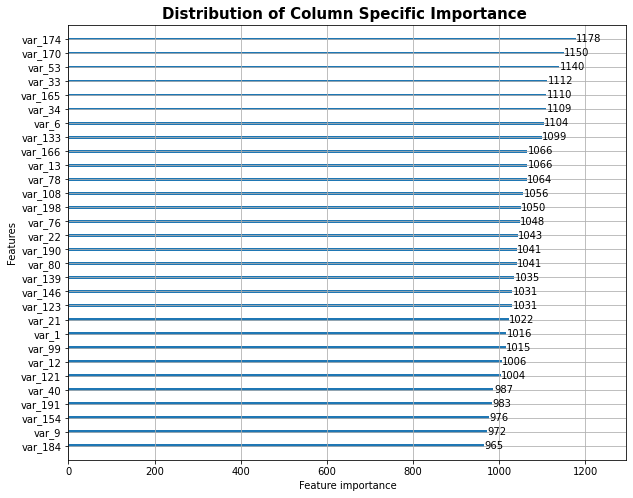

In [136]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(lgbm_model, max_num_features=30, ax=ax)
ax.set_title("Distribution of Column Specific Importance ", fontweight="bold", fontsize=15)
ax.patch.set_alpha(0) 
plt.show()